# Analyze Driver Subpopulations Behavior

1. How long will they drive for Lyft after onboarding?
2. What factors affect them?

In [38]:
# Necessary libs
import os
import numpy as np
import pandas as pd
import scipy
import sklearn
import datetime

from sklearn.linear_model import LinearRegression
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dabest

# custom libs
import sys
sys.path.append("../")
from src.data.rider import Fare, Ride

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

driver_ids = pd.read_csv('../data/raw/driver_ids.csv')
ride_ids = pd.read_csv('../data/interim/ride_ids_v2.csv')
ride_timestamps = pd.read_csv('../data/interim/ride_timestamps_v2.csv')

nride_df = pd.read_csv("../data/interim/master_ride.csv", index_col=False)
driver_profile = pd.read_csv('../data/interim/driver_week_profile.csv', index_col=False)

In [13]:
display(driver_ids.head(3))
display(ride_ids.head(3))
display(ride_timestamps.head(3))
display(driver_profile.head(2))
display(nride_df.head(2))

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.450000,7.489648,0.5191,0.4809,0.4986,6.243099,1.248620,True
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.0,2.089050,13.483333,9.118741,0.4475,0.5525,1.0737,9.118741,1.823748,False
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.0,2.039340,9.533333,8.192575,0.5279,0.4721,0.8885,8.192575,1.638515,False


,ride_id,event,timestamp,time_of_day,weekday,month,date,week_index
0,092ec855c70d70df6d4be5fb23e29081,accepted_at,2016-03-29 11:26:43,2,0.0,3,2016-03-29,1
1,a36318bb575fd2e0adefe8a9d5ecf5b3,accepted_at,2016-03-31 10:53:00,2,0.0,3,2016-03-31,1
2,a36318bb575fd2e0adefe8a9d5ecf5b3,arrived_at,2016-03-31 10:57:20,2,0.0,3,2016-03-31,1


,driver_id,days_driven,driver_onboard_date,week_onboard,week_start,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_timestamp
0,002be0ffdc997bd5c50703158b7c2491,87,2016-03-29,1,1,130.0,55.0,215.0,145.0,15.0,50.0,15.0,130.0,70.0,175.0,205.0,85.0,95.0,2016-03-28
1,007f0389f9c7b03ef97098422f902e62,86,2016-03-29,1,1,5.0,5.0,0.0,25.0,30.0,15.0,0.0,30.0,0.0,25.0,0.0,10.0,10.0,2016-03-28


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride,weeks_until_last_ride,days_until_last_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:22:07.000000000,25.0,3.0,64 days 21:37:18.000000000,61 days 08:07:46.000000000,8,61
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:13:50.000000000,25.0,3.0,64 days 21:45:35.000000000,61 days 08:16:03.000000000,8,61


# Sub Population Based on # Rides Given

,index,driver_id,event
0,0,002be0ffdc997bd5c50703158b7c2491,1385
1,1,007f0389f9c7b03ef97098422f902e62,155
2,2,011e5c5dfc5c2c92501b8b24d47509bc,170
3,3,0152a2f305e71d26cc964f8d4411add9,955
4,4,01674381af7edd264113d4e6ed55ecda,1875


(844, 3)
Computed quantile for 0.25 was 220.0.
Computed quantile for 0.4 was 415.0.
Computed quantile for 0.5 was 1119.5.
Computed quantile for 0.9 was 2292.0000000000005.


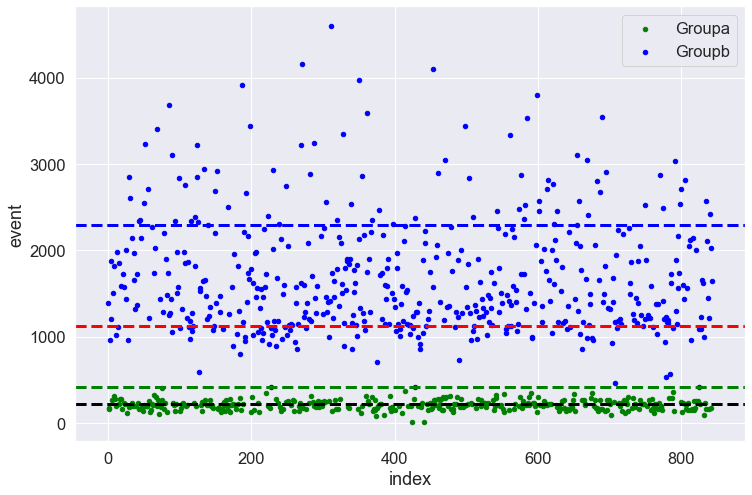

In [19]:
df = nride_df.copy()
test = df.groupby("driver_id")[['event']].count()
test.reset_index(inplace=True)
test.reset_index(inplace=True)
display(test.head())
print(test.shape)

groupainds = test["event"] < 415
groupbinds = test["event"] >= 415
groupa = test[groupainds]
groupb = test[groupbinds]
'''
Rides Per Driver
'''
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1,1, figsize=(12,8))
# test.plot(kind="scatter", x="index", y="event", ax=ax)

test[groupainds].plot(kind="scatter", x="index", y="event", ax=ax, color="green", label="Groupa")
test[groupbinds].plot(kind="scatter", x="index", y="event", ax=ax, color="blue", label="Groupb")

quantiles = [0.25, 0.4, 0.5, 0.9]
colors = ["black", "green", "red", "blue"]
for q, col in zip(quantiles, colors):
    computed_q = test["event"].quantile(q=q)
    print(f"Computed quantile for {q} was {computed_q}.")
    ax.axhline(computed_q, linestyle="--", linewidth=3,
               color=col, 
               label=f"Quantile {q}")

In [21]:
print(groupa)

groupa.drop("event", inplace=True, axis=1)
groupb.drop("event", inplace=True, axis=1)

print(groupa)

     index                         driver_id  event
1        1  007f0389f9c7b03ef97098422f902e62    155
2        2  011e5c5dfc5c2c92501b8b24d47509bc    170
6        6  021e5cd15ef0bb3ec20a12af99e142b3    265
9        9  02d6a6b8a6da15fc219a9570f7ebbe78    310
10      10  02e440f6c209206375833cef02e0cbae    280
..     ...                               ...    ...
831    831  fd831ca1d79ae5c6fc3a679a22e5b8cf     95
833    833  fdbee494c73577d5b1266d1fec5c6c9a    235
834    834  fde60697758e68d617f471e49f65db75    160
838    838  fed19d671569afe8a2f9fa0953dd25ca    165
841    841  fff482c704d36a1afe8b8978d5486283    175

[337 rows x 3 columns]
     index                         driver_id
1        1  007f0389f9c7b03ef97098422f902e62
2        2  011e5c5dfc5c2c92501b8b24d47509bc
6        6  021e5cd15ef0bb3ec20a12af99e142b3
9        9  02d6a6b8a6da15fc219a9570f7ebbe78
10      10  02e440f6c209206375833cef02e0cbae
..     ...                               ...
831    831  fd831ca1d79ae5c6fc3a679a2

/Users/adam2392/miniconda3/envs/lyft/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
groupa_df = nride_df.merge(groupa, how="right", on="driver_id")
groupb_df = nride_df.merge(groupb, how="right", on="driver_id")

print(nride_df.shape)
print(groupa_df.shape)
print(groupb_df.shape)

(924076, 30)
(69844, 31)
(854232, 31)


## Driver Profiles of Sub-population

In [25]:
driversa_summ = driver_profile.merge(groupa, how="right", on="driver_id")
driversb_summ = driver_profile.merge(groupb, how="right", on="driver_id")

display(driversa_summ.head(3))
display(driversb_summ.head(3))

,driver_id,days_driven,driver_onboard_date,week_onboard,week_start,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_timestamp,index
0,007f0389f9c7b03ef97098422f902e62,86.0,2016-03-29,1.0,1.0,5.0,5.0,0.0,25.0,30.0,15.0,0.0,30.0,0.0,25.0,0.0,10.0,10.0,2016-03-28,1
1,011e5c5dfc5c2c92501b8b24d47509bc,69.0,2016-04-05,2.0,2.0,0.0,35.0,20.0,0.0,5.0,25.0,10.0,25.0,25.0,0.0,25.0,0.0,0.0,2016-04-04,2
2,021e5cd15ef0bb3ec20a12af99e142b3,50.0,2016-05-07,6.0,6.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,55.0,60.0,20.0,5.0,5.0,80.0,2016-05-02,6


,driver_id,days_driven,driver_onboard_date,week_onboard,week_start,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_timestamp,index
0,002be0ffdc997bd5c50703158b7c2491,87.0,2016-03-29,1.0,1.0,130.0,55.0,215.0,145.0,15.0,50.0,15.0,130.0,70.0,175.0,205.0,85.0,95.0,2016-03-28,0
1,0152a2f305e71d26cc964f8d4411add9,63.0,2016-04-23,4.0,5.0,0.0,0.0,0.0,0.0,125.0,85.0,70.0,0.0,120.0,120.0,125.0,100.0,210.0,2016-04-25,3
2,01674381af7edd264113d4e6ed55ecda,57.0,2016-04-29,5.0,5.0,0.0,0.0,0.0,0.0,25.0,250.0,230.0,180.0,255.0,210.0,200.0,255.0,270.0,2016-04-25,4


# Effect of Stratifying Groups

In [54]:
driver_summ_profile = driversa_summ.copy()
driver_summ_profile.dropna(inplace=True)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
[1, 2, 3, 4, 5, 6, 7]


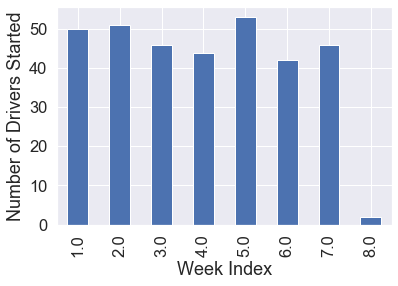

In [55]:
week_cols = [f"week_{i}" for i in range(1, 14)]

fig, ax = plt.subplots(1,1)
driver_summ_profile.groupby("week_start")["driver_id"].count().plot(kind="bar", ax=ax)
ax.set_xlabel("Week Index")
ax.set_ylabel("Number of Drivers Started")
# plt.savefig("../reports/figures/number_drivers_start_perweek.pdf")

# track each cohort over weeks within the dataset
week_cols = [f"week_{i}" for i in range(1, 14)]

cohort_list = []
cohort_hue = []
weekstartinds = sorted(driver_summ_profile["week_start"].unique())
print(weekstartinds)
for ind in weekstartinds[:-1]:
    weekstart_df = driver_summ_profile[driver_summ_profile["week_start"] == ind]
    
    week_stats = []
    for col in week_cols:
        result = len(weekstart_df[weekstart_df[col] > 0])
        week_stats.append(result)
    
    cohort_list.append(week_stats)
    cohort_hue.append(int(ind))
    
print(cohort_hue)

0.5610795096038315


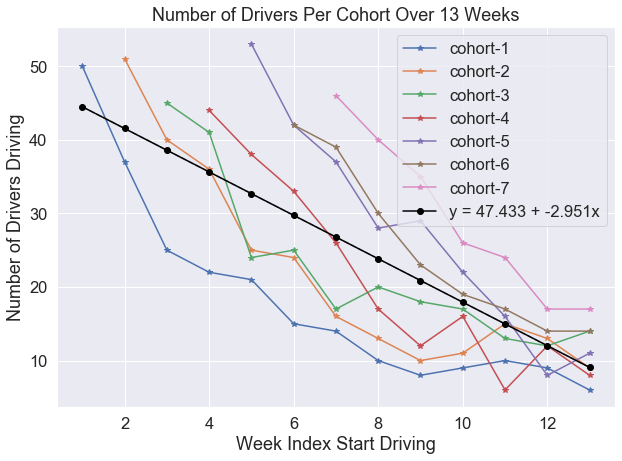

In [58]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
X = []
Y = []
for i in range(len(cohort_hue)):
    cohort_ind = cohort_hue[i]
    x = np.arange(cohort_ind, 14).tolist()
#     x = np.arange(0, 14 - cohort_ind).tolist()
    X.extend(x)
    y = cohort_list[i][cohort_ind-1:]
    Y.extend(y)
    ax.plot(np.arange(cohort_ind, 14), cohort_list[i][cohort_ind-1:], '-*', label=f"cohort-{cohort_hue[i]}")
    
lr = LinearRegression()
X = np.array(X)
Y = np.array(Y)
lr.fit(X[:, np.newaxis], Y)  # x needs to be 2d for LinearRegression
x = np.arange(1, 14)
ax.plot(x, lr.predict(x[:, np.newaxis]), linestyle='--')

print(lr.score(X[:, np.newaxis], Y))
coef = np.round(lr.coef_[0], 3)
intercept = np.round(lr.intercept_, 3)

lrstr = f"y = {intercept} + {coef}x" 

ax.plot(x, lr.predict(x[:, np.newaxis]), '-o', color='black', label=lrstr)
ax.set_xlabel("Week Index Start Driving")
ax.set_ylabel("Number of Drivers Driving")
ax.set_title("Number of Drivers Per Cohort Over 13 Weeks")
ax.legend()
plt.savefig("../reports/figures/cohorta_over_time.pdf")

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
[1, 2, 3, 4, 5, 6]
0.1630124926954075


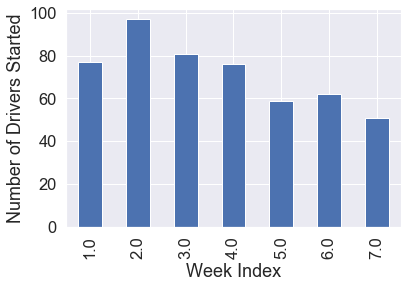

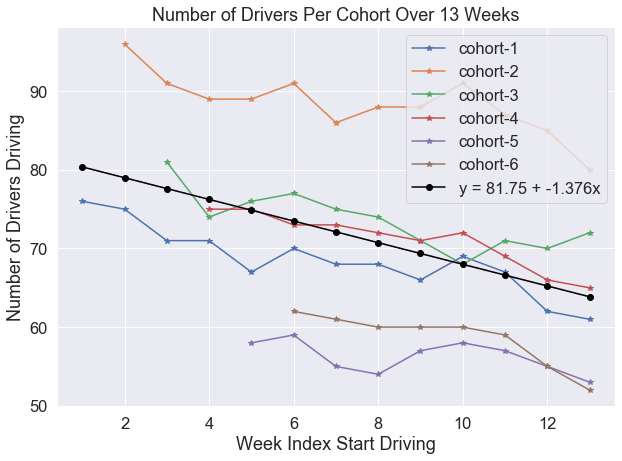

In [48]:
driver_summ_profile = driversb_summ.copy()
driver_summ_profile.dropna(inplace=True)

week_cols = [f"week_{i}" for i in range(1, 14)]

fig, ax = plt.subplots(1,1)
driver_summ_profile.groupby("week_start")["driver_id"].count().plot(kind="bar", ax=ax)
ax.set_xlabel("Week Index")
ax.set_ylabel("Number of Drivers Started")
# plt.savefig("../reports/figures/number_drivers_start_perweek.pdf")

# track each cohort over weeks within the dataset
week_cols = [f"week_{i}" for i in range(1, 14)]

cohort_list = []
cohort_hue = []
weekstartinds = sorted(driver_summ_profile["week_start"].unique())
print(weekstartinds)
for ind in weekstartinds[:-1]:
    weekstart_df = driver_summ_profile[driver_summ_profile["week_start"] == ind]
    
    week_stats = []
    for col in week_cols:
        result = len(weekstart_df[weekstart_df[col] > 0])
        week_stats.append(result)
    
    cohort_list.append(week_stats)
    cohort_hue.append(int(ind))
    
print(cohort_hue)

fig, ax = plt.subplots(1,1,figsize=(10,7))
X = []
Y = []
for i in range(len(cohort_hue)):
    cohort_ind = cohort_hue[i]
    X.extend(np.arange(cohort_ind, 14).tolist())
    y = cohort_list[i][cohort_ind-1:]
    Y.extend(y)
    ax.plot(np.arange(cohort_ind, 14), cohort_list[i][cohort_ind-1:], '-*', label=f"cohort-{cohort_hue[i]}")
    
lr = LinearRegression()
X = np.array(X)
Y = np.array(Y)
lr.fit(X[:, np.newaxis], Y)  # x needs to be 2d for LinearRegression
x = np.arange(1, 14)
ax.plot(x, lr.predict(x[:, np.newaxis]), linestyle='--')

print(lr.score(X[:, np.newaxis], Y))
coef = np.round(lr.coef_[0], 3)
intercept = np.round(lr.intercept_, 3)

lrstr = f"y = {intercept} + {coef}x" 

ax.plot(x, lr.predict(x[:, np.newaxis]), '-o', color='black', label=lrstr)
ax.set_xlabel("Week Index Start Driving")
ax.set_ylabel("Number of Drivers Driving")
ax.set_title("Number of Drivers Per Cohort Over 13 Weeks")
ax.legend()
plt.savefig("../reports/figures/cohortB_over_time.pdf")

# Analysis of Average Fare Within Each Subpopulation

In [49]:
groupa_df = nride_df.merge(groupa, how="right", on="driver_id")
groupb_df = nride_df.merge(groupb, how="right", on="driver_id")

print(nride_df.shape)
print(groupa_df.shape)
print(groupb_df.shape)

(924076, 30)
(69844, 31)
(854232, 31)


In [52]:
avg_fares = groupa_df.groupby("driver_id")["fare_total"].mean()
print(np.mean(avg_fares), " +/- ", avg_fares.sem())

13.556962094896068  +/-  0.13558017642663533


In [53]:
avg_fares = groupb_df.groupby("driver_id")["fare_total"].mean()
print(np.mean(avg_fares), " +/- ", avg_fares.sem())

13.194172067173337  +/-  0.0616448001118915


# Correlation Plots WRT Time of Week, Time of Day

* Driver revenue vs Time of Week
* Driver revenue vs Time of Day

,Count
day_of_week,
Monday,7523.0
Tuesday,8894.0
Sunday,9488.0
Wednesday,9815.0
Thursday,10593.0


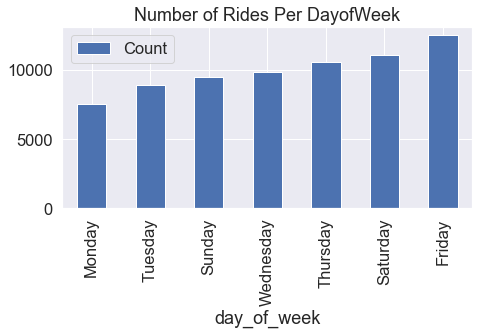

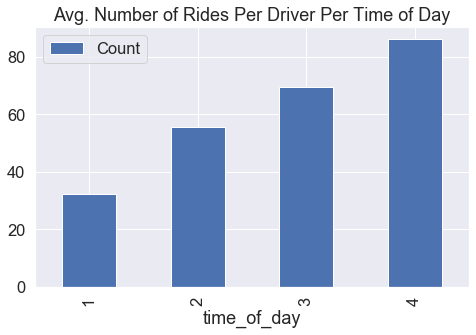

In [64]:
"""
Time of Day/Week
"""
df = groupa_df.copy()
test = df.groupby('driver_id')['day_of_week'].value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test = test.groupby("day_of_week").sum()
test.sort_values(by="Count", inplace=True)

display(test.head())

fig, ax = plt.subplots(1,1,figsize=(7,5))
test.plot(kind="bar", ax=ax)
ax.set_title("Number of Rides Per DayofWeek")
fig.tight_layout()
plt.savefig("../reports/figures/groupa_avg_number_rides_per_dayofweekdriver.pdf")

df = groupa_df.copy()
test = df.groupby('driver_id')['time_of_day'].value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test = test.groupby("time_of_day").agg("mean")

fig, ax = plt.subplots(1,1,figsize=(7,5))
test.plot(kind="bar", ax=ax)
ax.set_title("Avg. Number of Rides Per Driver Per Time of Day")
fig.tight_layout()
plt.savefig("../reports/figures/groupa_avg_number_rides_per_timeofdaydriver.pdf")


,Count
day_of_week,
Monday,94991.0
Sunday,105416.0
Tuesday,110713.0
Wednesday,120599.0
Thursday,131415.0


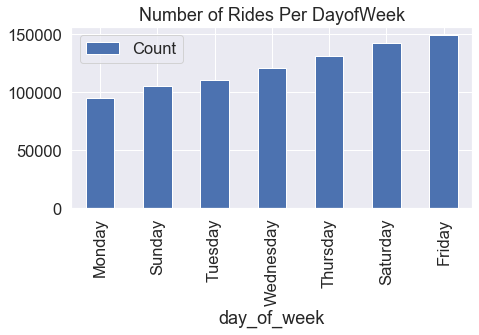

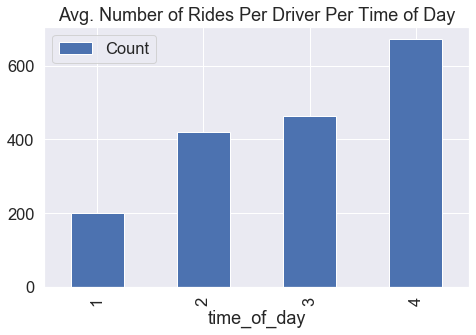

In [65]:
"""
Time of Day/Week
"""
df = groupb_df.copy()
test = df.groupby('driver_id')['day_of_week'].value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test = test.groupby("day_of_week").sum()
test.sort_values(by="Count", inplace=True)

display(test.head())

fig, ax = plt.subplots(1,1,figsize=(7,5))
test.plot(kind="bar", ax=ax)
ax.set_title("Number of Rides Per DayofWeek")
fig.tight_layout()
plt.savefig("../reports/figures/groupb_avg_number_rides_per_dayofweekdriver.pdf")

df = groupb_df.copy()
test = df.groupby('driver_id')['time_of_day'].value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test = test.groupby("time_of_day").agg("mean")

fig, ax = plt.subplots(1,1,figsize=(7,5))
test.plot(kind="bar", ax=ax)
ax.set_title("Avg. Number of Rides Per Driver Per Time of Day")
fig.tight_layout()
plt.savefig("../reports/figures/groupb_avg_number_rides_per_timeofdaydriver.pdf")


# Correlation Plots WRT PT

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride,weeks_until_last_ride,days_until_last_ride,index
0,007f0389f9c7b03ef97098422f902e62,01f133164433ea7682545a41643e6949,4711,856,0.25,2.92728,14.266667,11.881298,0.5175,0.4825,1.301,10.255038,2.051008,True,dropped_off_at,2016-05-18 21:27:51,4,0.0,5,2016-05-18,8,Wednesday,2016-03-29 00:00:00,50 days 21:27:51.000000000,50.0,7.0,39 days 02:31:34.000000000,34 days 16:00:47.000000000,4,34,1
1,007f0389f9c7b03ef97098422f902e62,01f133164433ea7682545a41643e6949,4711,856,0.25,2.92728,14.266667,11.881298,0.5175,0.4825,1.301,10.255038,2.051008,True,picked_up_at,2016-05-18 21:13:35,4,0.0,5,2016-05-18,8,Wednesday,2016-03-29 00:00:00,50 days 21:13:35.000000000,50.0,7.0,39 days 02:45:50.000000000,34 days 16:15:03.000000000,4,34,1
2,007f0389f9c7b03ef97098422f902e62,01f133164433ea7682545a41643e6949,4711,856,0.25,2.92728,14.266667,11.881298,0.5175,0.4825,1.301,10.255038,2.051008,True,arrived_at,2016-05-18 21:13:32,4,0.0,5,2016-05-18,8,Wednesday,2016-03-29 00:00:00,50 days 21:13:32.000000000,50.0,7.0,39 days 02:45:53.000000000,34 days 16:15:06.000000000,4,34,1
3,007f0389f9c7b03ef97098422f902e62,01f133164433ea7682545a41643e6949,4711,856,0.25,2.92728,14.266667,11.881298,0.5175,0.4825,1.301,10.255038,2.051008,True,accepted_at,2016-05-18 21:12:52,4,0.0,5,2016-05-18,8,Wednesday,2016-03-29 00:00:00,50 days 21:12:52.000000000,50.0,7.0,39 days 02:46:33.000000000,34 days 16:15:46.000000000,4,34,1
4,007f0389f9c7b03ef97098422f902e62,01f133164433ea7682545a41643e6949,4711,856,0.25,2.92728,14.266667,11.881298,0.5175,0.4825,1.301,10.255038,2.051008,True,requested_at,2016-05-18 21:12:45,4,0.0,5,2016-05-18,8,Wednesday,2016-03-29 00:00:00,50 days 21:12:45.000000000,50.0,7.0,39 days 02:46:40.000000000,34 days 16:15:53.000000000,4,34,1


(69844, 31)


,sum,mean,sem
day_of_week,,,
Tuesday,1999.0,0.224758,0.004426
Monday,1792.0,0.238203,0.004912
Thursday,2740.0,0.258661,0.004255
Wednesday,2559.0,0.260723,0.004432
Saturday,3260.0,0.295049,0.004339


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride,weeks_until_last_ride,days_until_last_ride,index
0,007f0389f9c7b03ef97098422f902e62,01f133164433ea7682545a41643e6949,4711,856,0.25,2.92728,14.266667,11.881298,0.5175,0.4825,1.301,10.255038,2.051008,True,dropped_off_at,2016-05-18 21:27:51,4,0.0,5,2016-05-18,8,Wednesday,2016-03-29 00:00:00,50 days 21:27:51.000000000,50.0,7.0,39 days 02:31:34.000000000,34 days 16:00:47.000000000,4,34,1
1,007f0389f9c7b03ef97098422f902e62,01f133164433ea7682545a41643e6949,4711,856,0.25,2.92728,14.266667,11.881298,0.5175,0.4825,1.301,10.255038,2.051008,True,picked_up_at,2016-05-18 21:13:35,4,0.0,5,2016-05-18,8,Wednesday,2016-03-29 00:00:00,50 days 21:13:35.000000000,50.0,7.0,39 days 02:45:50.000000000,34 days 16:15:03.000000000,4,34,1
2,007f0389f9c7b03ef97098422f902e62,01f133164433ea7682545a41643e6949,4711,856,0.25,2.92728,14.266667,11.881298,0.5175,0.4825,1.301,10.255038,2.051008,True,arrived_at,2016-05-18 21:13:32,4,0.0,5,2016-05-18,8,Wednesday,2016-03-29 00:00:00,50 days 21:13:32.000000000,50.0,7.0,39 days 02:45:53.000000000,34 days 16:15:06.000000000,4,34,1
3,007f0389f9c7b03ef97098422f902e62,01f133164433ea7682545a41643e6949,4711,856,0.25,2.92728,14.266667,11.881298,0.5175,0.4825,1.301,10.255038,2.051008,True,accepted_at,2016-05-18 21:12:52,4,0.0,5,2016-05-18,8,Wednesday,2016-03-29 00:00:00,50 days 21:12:52.000000000,50.0,7.0,39 days 02:46:33.000000000,34 days 16:15:46.000000000,4,34,1
4,007f0389f9c7b03ef97098422f902e62,01f133164433ea7682545a41643e6949,4711,856,0.25,2.92728,14.266667,11.881298,0.5175,0.4825,1.301,10.255038,2.051008,True,requested_at,2016-05-18 21:12:45,4,0.0,5,2016-05-18,8,Wednesday,2016-03-29 00:00:00,50 days 21:12:45.000000000,50.0,7.0,39 days 02:46:40.000000000,34 days 16:15:53.000000000,4,34,1


(69844, 31)


,sum,mean,sem
time_of_day,,,
2,3367.0,0.241016,0.003619
3,5898.0,0.265604,0.002964
1,1674.0,0.278768,0.005787
4,8650.0,0.312692,0.002787


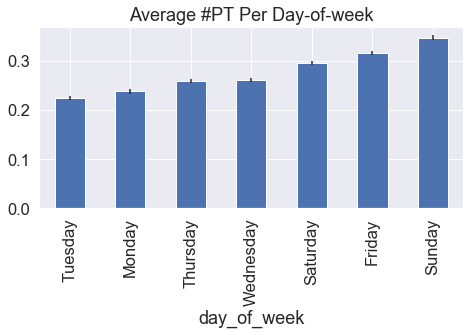

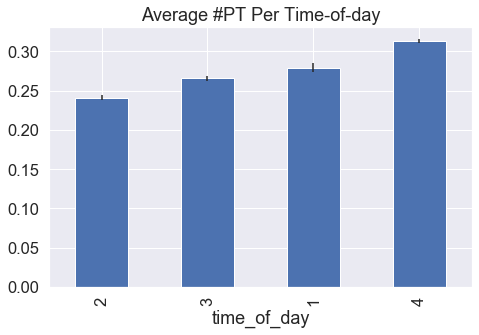

In [63]:
df = groupa_df.copy()
display(df.head())
print(df.shape)
test = df.groupby("day_of_week")['is_prime_time'].agg(["sum", "mean", "sem"])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test.sort_values(by="mean", inplace=True)
display(test.head())
std = test["sem"]

fig, ax = plt.subplots(1,1, figsize=(7,5))
test["mean"].plot(kind="bar", ax=ax, yerr=std)
ax.set_title("Average #PT Per Day-of-week")
fig.tight_layout()
plt.savefig("../reports/figures/groupa_avg_number_pt_per_dayofweek.pdf")

df = groupa_df.copy()
display(df.head())
print(df.shape)
test = df.groupby("time_of_day")['is_prime_time'].agg(["sum", "mean", "sem"])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test.sort_values(by="mean", inplace=True)
display(test.head())
std = test["sem"]

fig, ax = plt.subplots(1,1, figsize=(7,5))
test["mean"].plot(kind="bar", ax=ax, yerr=std)
ax.set_title("Average #PT Per Time-of-day")
fig.tight_layout()
plt.savefig("../reports/figures/groupa_avg_number_pt_per_timeofday.pdf")

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride,weeks_until_last_ride,days_until_last_ride,index
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:22:07.000000000,25.0,3.0,64 days 21:37:18.000000000,61 days 08:07:46.000000000,8,61,0
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:13:50.000000000,25.0,3.0,64 days 21:45:35.000000000,61 days 08:16:03.000000000,8,61,0
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:14:15.000000000,25.0,3.0,64 days 21:45:10.000000000,61 days 08:15:38.000000000,8,61,0
3,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,arrived_at,2016-04-23 02:16:36,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:16:36.000000000,25.0,3.0,64 days 21:42:49.000000000,61 days 08:13:17.000000000,8,61,0
4,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,picked_up_at,2016-04-23 02:16:40,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:16:40.000000000,25.0,3.0,64 days 21:42:45.000000000,61 days 08:13:13.000000000,8,61,0


(854232, 31)


,sum,mean,sem
day_of_week,,,
Tuesday,33753.0,0.304869,0.001384
Wednesday,38829.0,0.321968,0.001345
Thursday,46229.0,0.351779,0.001317
Monday,33542.0,0.353107,0.001551
Saturday,51278.0,0.360914,0.001274


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week,driver_onboard_date,time_since_onboard,days_since_onboard,weeks_since_onboard,time_until_last_event,time_until_last_ride,weeks_until_last_ride,days_until_last_ride,index
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,dropped_off_at,2016-04-23 02:22:07,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:22:07.000000000,25.0,3.0,64 days 21:37:18.000000000,61 days 08:07:46.000000000,8,61,0
1,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:13:50.000000000,25.0,3.0,64 days 21:45:35.000000000,61 days 08:16:03.000000000,8,61,0
2,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,accepted_at,2016-04-23 02:14:15,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:14:15.000000000,25.0,3.0,64 days 21:45:10.000000000,61 days 08:15:38.000000000,8,61,0
3,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,arrived_at,2016-04-23 02:16:36,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:16:36.000000000,25.0,3.0,64 days 21:42:49.000000000,61 days 08:13:17.000000000,8,61,0
4,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.5,1.125303,5.45,7.489648,0.5191,0.4809,0.4986,6.243099,1.24862,True,picked_up_at,2016-04-23 02:16:40,1,1.0,4,2016-04-23,4,Saturday,2016-03-29 00:00:00,25 days 02:16:40.000000000,25.0,3.0,64 days 21:42:45.000000000,61 days 08:13:13.000000000,8,61,0


(854232, 31)


,sum,mean,sem
time_of_day,,,
2,66004.0,0.324657,0.001038
1,28918.0,0.333237,0.001600
3,85458.0,0.367947,0.001001
4,126736.0,0.381858,0.000843


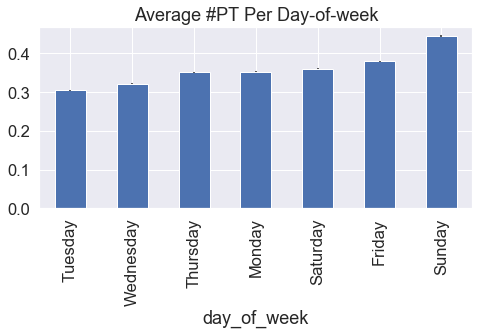

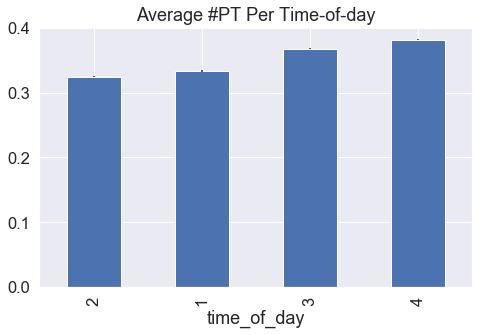

In [62]:
df = groupb_df.copy()
display(df.head())
print(df.shape)
test = df.groupby("day_of_week")['is_prime_time'].agg(["sum", "mean", "sem"])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test.sort_values(by="mean", inplace=True)
display(test.head())
std = test["sem"]

fig, ax = plt.subplots(1,1, figsize=(7,5))
test["mean"].plot(kind="bar", ax=ax, yerr=std)
ax.set_title("Average #PT Per Day-of-week")
fig.tight_layout()
plt.savefig("../reports/figures/groupb_avg_number_pt_per_dayofweek.pdf")

df = groupb_df.copy()
display(df.head())
print(df.shape)
test = df.groupby("time_of_day")['is_prime_time'].agg(["sum", "mean", "sem"])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test.sort_values(by="mean", inplace=True)
display(test.head())
std = test["sem"]

fig, ax = plt.subplots(1,1, figsize=(7,5))
test["mean"].plot(kind="bar", ax=ax, yerr=std)
ax.set_title("Average #PT Per Time-of-day")
fig.tight_layout()
plt.savefig("../reports/figures/groupb_avg_number_pt_per_timeofday.pdf")

# Correlation Plots WRT Number Rides

# Correlation Plots WRT Longer Rides (time and mileage)

ride_distance                     ride_duration                   ride_prime_time                 ride_distance_miles                 ride_duration_mins                  fare_total                  mile_perc                 time_perc                  lyft_rev                 pre_pt_fare                  pre_pt_lyft_rev                 is_prime_time                 time_of_day                   weekday                     month                 week_index                 days_since_onboard                  weeks_since_onboard                 weeks_until_last_ride                 days_until_last_ride                 
                                          mean count           std          mean count         std            mean count       std                mean count       std               mean count        std       mean count        std      mean count       std      mean count       std      mean count       std        mean count        std            mean count       std          mean count       std        mean count       std      mean count       std      mean count       std       mean count       std               mean count        std                mean count       std                  mean count       std                 mean count        std
driver_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
002be0ffdc997bd5c50703158b7c2491   6282.624549  1385   9415.981873    798.693141  1385  501.180899        0.194043  1385  0.310915            3.903842  1385  5.850820          13.311552  1385   8.353015  12.500032  1385   9.528023  0.543788  1385  0.097582  0.456212  1385  0.097582  1.489518  1385  1.664200   11.197588  1385   8.320995        2.239518  1385  1.664199      0.397112  1385  0.489476    2.950903  1385  1.135559  0.230325  1385  0.421193  4.949458  1385  0.978993   7.129964  1385  3.959386          44.832491  1385  27.631780            6.079422  1385  3.924068              5.368231  1385  3.902923            40.471480  1385  27.521788
007f0389f9c7b03ef97098422f902e62   3791.322581   155   2053.126858    661.193548   155  263.966303        0.201613   155  0.280735            2.355819   155  1.275754          11.019892   155   4.399438  10.024319   155   3.168507  0.523142   155  0.075917  0.476858   155  0.075917  1.034423   155  0.445317    8.922110   155   2.226568        1.784422   155  0.445314      0.387097   155  0.488665    3.632258   155  0.483754  0.290323   155  0.455383  4.838710   155  0.886287   7.064516   155  3.151329          44.967742   155  21.729571            6.064516   155  3.151329              5.096774   155  3.008158            39.096774   155  21.611016
011e5c5dfc5c2c92501b8b24d47509bc   7930.970588   170  14680.161414    858.970588   170  734.887686        0.198529   170  0.256422            4.928077   170  9.121829          14.316176   170  12.248128  13.820695   170  13.229533  0.547897   170  0.105344  0.452103   170  0.105344  1.768600   170  2.621851   12.593039   170  13.109212        2.518608   170  2.621842      0.470588   170  0.500609    3.370588   170  0.941021  0.470588   170  0.500609  4.794118   170  0.678469   6.323529   170  3.159662          33.117647   170  22.496239            4.323529   170  3.159662              4.588235   170  3.106756            34.676471   170  22.532975
0152a2f305e71d26cc964f8d4411add9   7702.821990   955   6647.587036    913.722513   955  546.636860     

(844, 60)


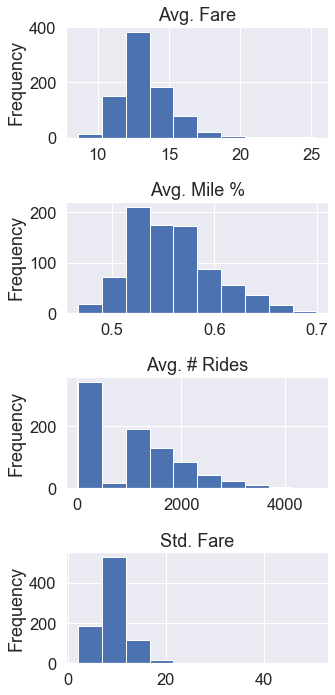

In [71]:
driver_summ = nride_df.groupby(['driver_id']).agg(['mean', 'count', 'std'])

display(driver_summ.head())
print(driver_summ.shape)

f, a = plt.subplots(4,1, figsize=(5,10))
driver_summ.xs(('fare_total', 'mean'), axis=1).plot(kind='hist', title="Avg. Fare", ax=a[0])
driver_summ.xs(('mile_perc','mean'), axis=1).plot(kind='hist',ax=a[1], title="Avg. Mile %")
driver_summ.xs(('fare_total', 'count'), axis=1).plot(kind='hist', title="Avg. # Rides", ax=a[2])
driver_summ.xs(('fare_total', 'std'), axis=1).plot(kind='hist', title="Std. Fare", ax=a[3])
# driver_summ.xs(('time_perc', 'mean'), axis=1).plot(kind='hist',ax=a[2], title="Avg. Time %")

f.tight_layout()

In [72]:
driver_summ = groupa_df.groupby(['driver_id']).agg(['mean', 'count', 'std'])

display(driver_summ.head())
print(driver_summ.shape)

ride_distance                     ride_duration                    ride_prime_time                 ride_distance_miles                  ride_duration_mins                  fare_total                  mile_perc                 time_perc                  lyft_rev                  pre_pt_fare                  pre_pt_lyft_rev                  is_prime_time                 time_of_day                   weekday                     month                 week_index                 days_since_onboard                  weeks_since_onboard                 weeks_until_last_ride                 days_until_last_ride                  index           
                                          mean count           std          mean count          std            mean count       std                mean count        std               mean count        std       mean count        std      mean count       std      mean count       std      mean count        std        mean count        std            mean count        std          mean count       std        mean count       std      mean count       std      mean count       std       mean count       std               mean count        std                mean count       std                  mean count       std                 mean count        std  mean count  std
driver_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
007f0389f9c7b03ef97098422f902e62   3791.322581   155   2053.126858    661.193548   155   263.966303        0.201613   155  0.280735            2.355819   155   1.275754          11.019892   155   4.399438  10.024319   155   3.168507  0.523142   155  0.075917  0.476858   155  0.075917  1.034423   155   0.445317    8.922110   155   2.226568        1.784422   155   0.445314      0.387097   155  0.488665    3.632258   155  0.483754  0.290323   155  0.455383  4.838710   155  0.886287   7.064516   155  3.151329          44.967742   155  21.729571            6.064516   155  3.151329              5.096774   155  3.008158            39.096774   155  21.611016     1   155  0.0
011e5c5dfc5c2c92501b8b24d47509bc   7930.970588   170  14680.161414    858.970588   170   734.887686        0.198529   170  0.256422            4.928077   170   9.121829          14.316176   170  12.248128  13.820695   170  13.229533  0.547897   170  0.105344  0.452103   170  0.105344  1.768600   170   2.621851   12.593039   170  13.109212        2.518608   170   2.621842      0.470588   170  0.500609    3.370588   170  0.941021  0.470588   170  0.500609  4.794118   170  0.678469   6.323529   170  3.159662          33.117647   170  22.496239            4.323529   170  3.159662              4.588235   170  3.106756            34.676471   170  22.532975     2   170  0.0
021e5cd15ef0bb3ec20a12af99e142b3   4861.698113   265   4218.724484    951.830189   265   518.293775        0.226415   265  0.288938            3.020919   265   2.621394          15.863836   265   8.638230  12.552693   265   6.955825  0.489409   265  0.092866  0.510591   265  0.092866  1.401994   265   0.896564   10.760004   265   4.482797        2.152001   265   0.896559      0.490566   265  0.500857    3.233962   265  0.607698  0.396226   265  0.490038  5.415094   265  0.493671   9.792453   265  2.394426          25.584906   265  16.495447            3.188679   265  2.335956              3.056604   265  2.330749            23.373585   265  16.5

(337, 63)


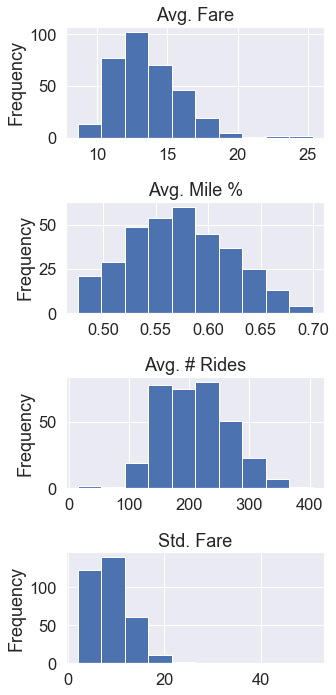

In [73]:
f, a = plt.subplots(4,1, figsize=(5,10))
driver_summ.xs(('fare_total', 'mean'), axis=1).plot(kind='hist', title="Avg. Fare", ax=a[0])
driver_summ.xs(('mile_perc','mean'), axis=1).plot(kind='hist',ax=a[1], title="Avg. Mile %")
driver_summ.xs(('fare_total', 'count'), axis=1).plot(kind='hist', title="Avg. # Rides", ax=a[2])
driver_summ.xs(('fare_total', 'std'), axis=1).plot(kind='hist', title="Std. Fare", ax=a[3])
# driver_summ.xs(('time_perc', 'mean'), axis=1).plot(kind='hist',ax=a[2], title="Avg. Time %")

f.tight_layout()

ride_distance                    ride_duration                   ride_prime_time                 ride_distance_miles                 ride_duration_mins                 fare_total                 mile_perc                 time_perc                  lyft_rev                 pre_pt_fare                 pre_pt_lyft_rev                 is_prime_time                 time_of_day                   weekday                     month                 week_index                 days_since_onboard                  weeks_since_onboard                 weeks_until_last_ride                 days_until_last_ride                  index           
                                          mean count          std          mean count         std            mean count       std                mean count       std               mean count       std       mean count       std      mean count       std      mean count       std      mean count       std        mean count       std            mean count       std          mean count       std        mean count       std      mean count       std      mean count       std       mean count       std               mean count        std                mean count       std                  mean count       std                 mean count        std  mean count  std
driver_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
002be0ffdc997bd5c50703158b7c2491   6282.624549  1385  9415.981873    798.693141  1385  501.180899        0.194043  1385  0.310915            3.903842  1385  5.850820          13.311552  1385  8.353015  12.500032  1385  9.528023  0.543788  1385  0.097582  0.456212  1385  0.097582  1.489518  1385  1.664200   11.197588  1385  8.320995        2.239518  1385  1.664199      0.397112  1385  0.489476    2.950903  1385  1.135559  0.230325  1385  0.421193  4.949458  1385  0.978993   7.129964  1385  3.959386          44.832491  1385  27.631780            6.079422  1385  3.924068              5.368231  1385  3.902923            40.471480  1385  27.521788     0  1385  0.0
0152a2f305e71d26cc964f8d4411add9   7702.821990   955  6647.587036    913.722513   955  546.636860        0.107330   955  0.213225            4.786312   955  4.130619          15.228709   955  9.110614  13.488869   955  6.845418  0.587894   955  0.093542  0.412106   955  0.093542  1.779552   955  1.286823   12.647754   955  6.434137        2.529551   955  1.286827      0.251309   955  0.433993    2.356021   955  1.172248  0.203141   955  0.402548  5.439791   955  0.713223   9.643979   955  2.809268          37.713089   955  19.733428            4.847120   955  2.837248              3.350785   955  2.810859            25.861780   955  19.590883     3   955  0.0
01674381af7edd264113d4e6ed55ecda   8329.717333  1875  9593.059088    953.181333  1875  552.367973        0.125333  1875  0.258187            5.175846  1875  5.960851          15.886356  1875  9.206133  14.122798  1875  8.988724  0.557415  1875  0.119204  0.442585  1875  0.119204  1.893741  1875  1.715384   13.218699  1875  8.576913        2.643740  1875  1.715383      0.264000  1875  0.440917    2.235733  1875  0.424570  0.000000  1875  0.000000  5.458667  1875  0.524504   9.514667  1875  2.409332          29.642667  1875  16.938595            3.744000  1875  2.406980              3.478400  1875  2.405955            26.315733  1875  16.944556     4  1875  0.0
0213f8b59219e32142711992c

(507, 63)


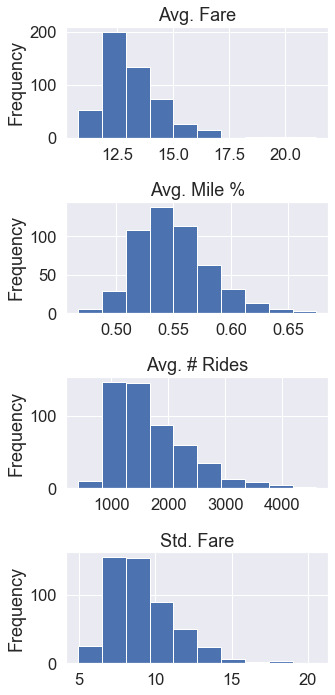

In [74]:
driver_summ = groupb_df.groupby(['driver_id']).agg(['mean', 'count', 'std'])

display(driver_summ.head())
print(driver_summ.shape)

f, a = plt.subplots(4,1, figsize=(5,10))
driver_summ.xs(('fare_total', 'mean'), axis=1).plot(kind='hist', title="Avg. Fare", ax=a[0])
driver_summ.xs(('mile_perc','mean'), axis=1).plot(kind='hist',ax=a[1], title="Avg. Mile %")
driver_summ.xs(('fare_total', 'count'), axis=1).plot(kind='hist', title="Avg. # Rides", ax=a[2])
driver_summ.xs(('fare_total', 'std'), axis=1).plot(kind='hist', title="Std. Fare", ax=a[3])
# driver_summ.xs(('time_perc', 'mean'), axis=1).plot(kind='hist',ax=a[2], title="Avg. Time %")

f.tight_layout()